Totals (kJ): Joule 110.94, Activation 20.83, Reaction enthalpy -7.76, Removed by convective loss 116.26


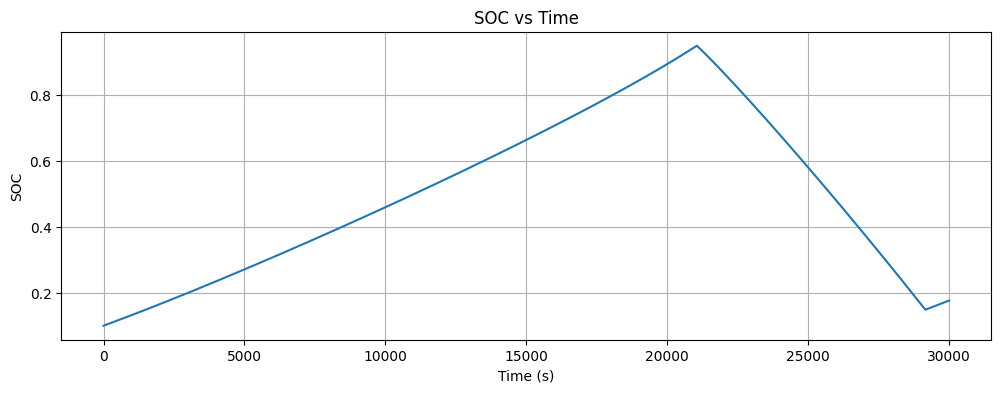

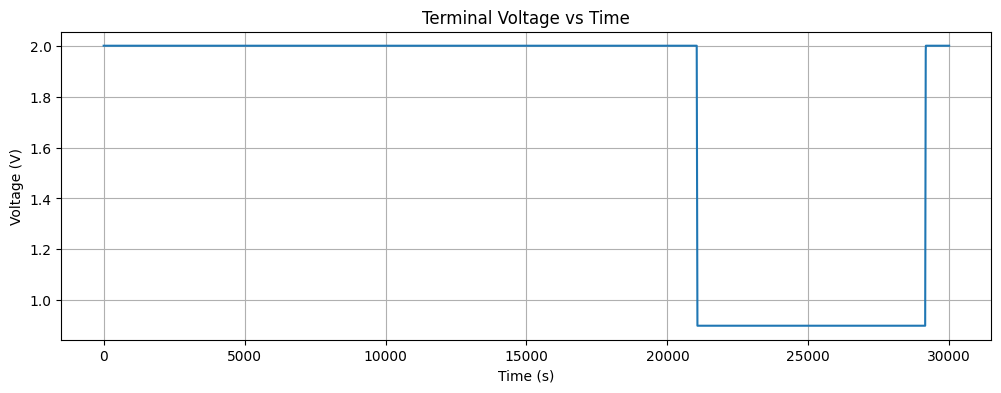

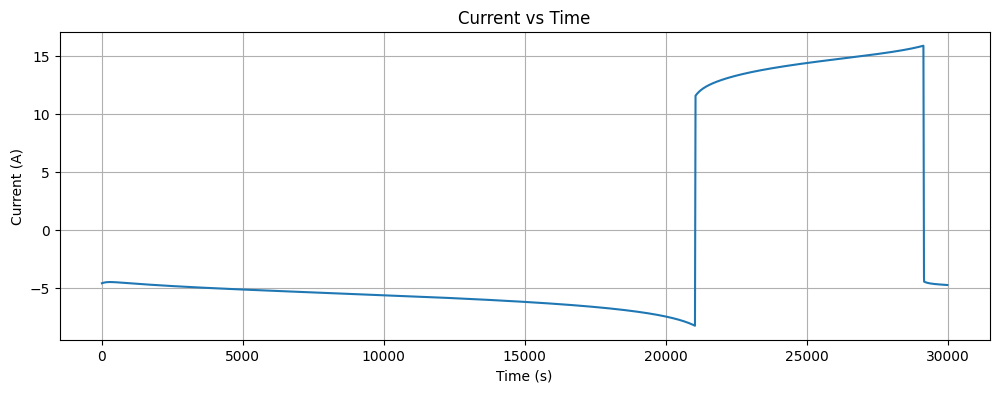

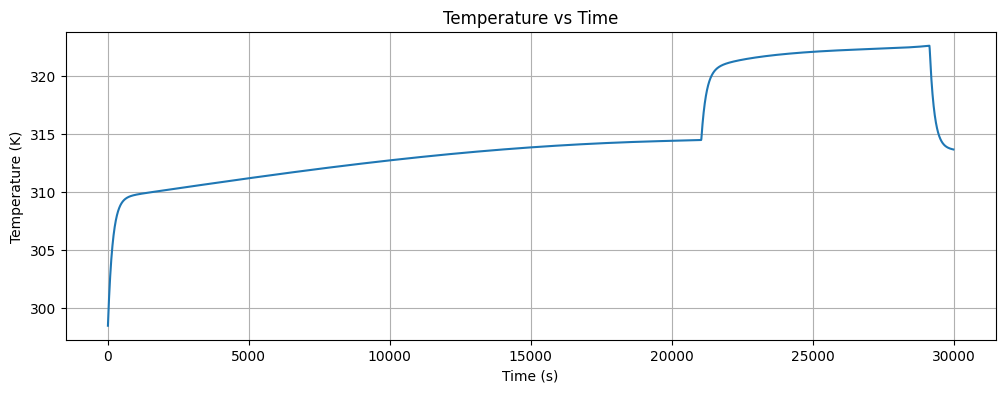

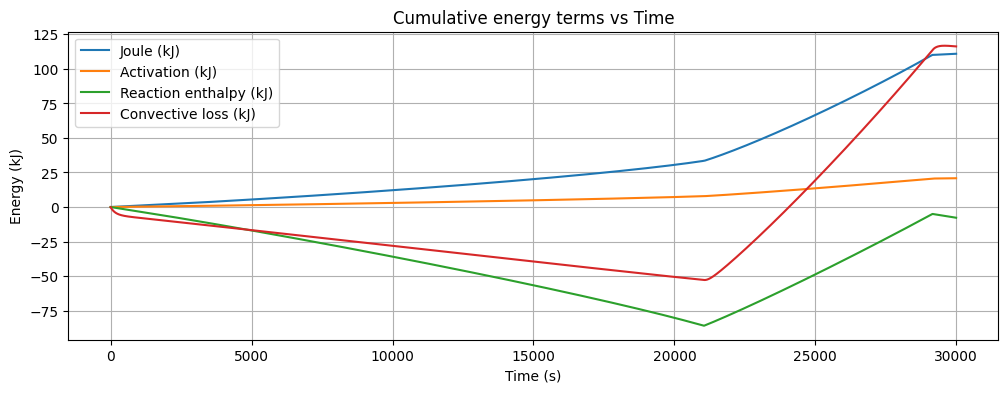

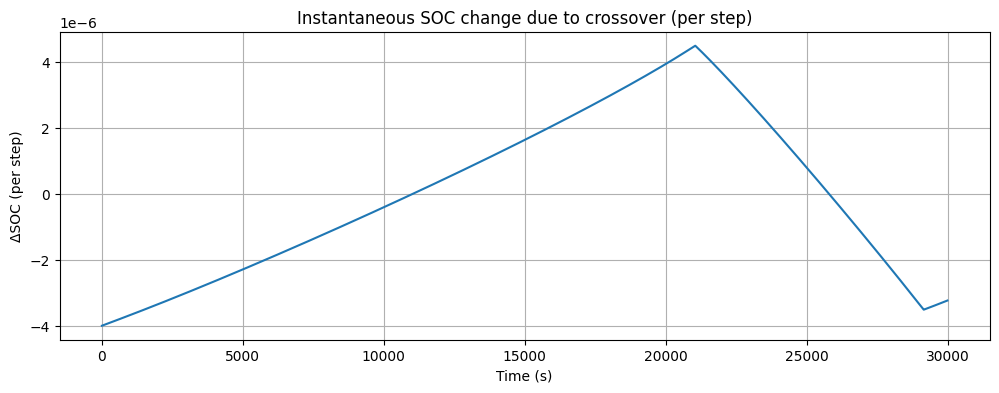

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# CONSTANTS 

F = 96485.33     
R = 8.314        
T0 = 298.15      
n = 1            
E0 = 1.26        

C_tot = 1500.0        
V_elec = 0.001        # 1 L
A = 0.04       # m^2              
i0 = 50.0              
alpha = 0.5
dt = 5.0               
T_amb_base = 310.15     # 37 degree         

H_plus_init = 1000.0   # mol/m^3  (~1 M acid)

# Ohmic model params
R_ref = 0.05      
Q_ref = 1.67e-5
beta = 0.25

# Controller limits
I_max = 20.0      
dI_max = 5.0       

# CROSSOVER params (simple first-order SOC drift toward 0.5)
# Typical k_cross range in literature: ~1e-6 ... 1e-4 s^-1 (depends on membrane & conditions)
k_cross = 2e-6   # s^-1 (tune this)

# Reaction enthalpy (J per mol of electrons transferred basis)
# Literature shows reaction enthalpies of tens to a few hundred kJ/mol depending on reaction;
# for a simple model we can use a single effective ΔH per mole of reaction (J/mol).
# Negative = exothermic on discharge (produces heat), positive = endothermic
# Example value (discharge exothermic): -67.4e3 J/mol (from thermal studies). Tweak as needed.
deltaH_rxn = -67.4e3  # J/mol

# THERMAL params
C_th = 500.0     # heat capacity of the stack (J/K) - tune to match system size
hA = 3.0         # overall heat transfer coefficient * area (W/K)
T_min = 250
T_max = 500

# electrochemical stoichiometry for reaction heat: per electron transferred
# Q_rxn (W) = - I (A) * deltaH_rxn / F   (since A = C/s, and F coulombs per mol e-)
# (positive Q_rxn → heat generation; sign from deltaH and I)
# Note: careful sign: for I>0 (discharge in your convention) and deltaH_rxn negative, Q_rxn>0 (heat gen)

# SIMULATION parameters
timesteps = 6000

# -----------------------------
# FUNCTIONS (your originals, slightly adapted)
# -----------------------------
def soc_coulomb(I, n, C_tot, V_elec, dt, soc_prev):
    soc_new = soc_prev - (I * dt) / (n * F * C_tot * V_elec)
    return float(np.clip(soc_new, 1e-6, 1 - 1e-6))

def crossover_SOC(SOC, k_cross, dt):
    SOC_eq = 0.5
    SOC_new = SOC + (-k_cross * (SOC - SOC_eq)) * dt
    return float(np.clip(SOC_new, 1e-6, 1 - 1e-6))

def n_act(I, A, T, i0, alpha, n=1):
    j = np.abs(I) / A     # Current density
    arg = np.maximum(1e-12, j/(2*i0))
    eta = (R*T)/(alpha*n*F) * np.arcsinh(arg)
    return np.sign(I) * eta

def E_ocv_osc(soc, E0, T, H_plus):
    soc = np.clip(soc, 1e-3, 1-1e-3)
    return E0 + (2*R*T/F)*(np.log((1-soc)/soc) + np.log(H_plus))

def R_ohm_func(T, Q, R_ref=R_ref, T_ref=298.15, Q_ref=Q_ref, beta=beta):
    T = max(250, T)
    Q = max(1e-9, Q)
    return float(R_ref * (T_ref/T) * (Q_ref/Q)**beta)

def ambient_temperature_time(t, T_mean=T_amb_base, amplitude=5.0, period=24*3600):
    # t in seconds; returns ambient temperature (K)
    return T_mean + amplitude * np.sin(2*np.pi * t / period)

def temperature_next(T_prev, I, R_ohm, eta_act, T_amb,
                     C_th=C_th, hA=hA, dt=1.0, deltaH=deltaH_rxn):
    # Q terms in Watts (J/s)
    Q_joule = I**2 * R_ohm                      # Joule heating
    Q_activation = abs(I) * abs(eta_act)        # activation/overpotential heating term
    Q_rxn = - I * (deltaH) / F                  # reaction enthalpy contribution (J/s)
    Q_gen = Q_joule + Q_activation + Q_rxn
    Q_loss = hA * (T_prev - T_amb)
    dTdt = (Q_gen - Q_loss) / C_th
    T_new = T_prev + dTdt * dt
    return float(np.clip(T_new, T_min, T_max)), Q_joule, Q_activation, Q_rxn, Q_loss

def update_step(SOC, I, R_ohm, E0, T, H_plus, dt, n, C_tot, V_elec):
    E_ocv = E_ocv_osc(SOC, E0, T, H_plus)
    eta_act = n_act(I, A, T, i0, alpha)
    V_t = E_ocv - I * R_ohm - eta_act
    SOC_new = soc_coulomb(I, n, C_tot, V_elec, dt, SOC)
    return SOC_new, float(V_t), float(eta_act), float(E_ocv)

def update_H_plus(H, I, V_elec, dt):
    nu_H = 2.0
    delta_H = -(nu_H * I * dt) / (F * V_elec)
    H_new = H + delta_H
    return float(np.clip(H_new, 1e-3, 5000))

def compute_current(V_set, SOC, T, Q, I_prev, H_plus):
    R_ohm = R_ohm_func(T, Q)
    E_ocv = E_ocv_osc(SOC, E0, T, H_plus)
    I = I_prev
    # simple iterative solve
    for _ in range(30):
        eta = n_act(I, A, T, i0, alpha)
        V_t = E_ocv - I * R_ohm - eta
        err = V_t - V_set
        I += 0.5 * err / (R_ohm + 1e-6)
    I = np.clip(I, -I_max, I_max)
    I = I_prev + np.clip(I - I_prev, -dI_max, dI_max)
    return float(I), R_ohm, E_ocv

# -----------------------------
# RUN SIM
# -----------------------------
def run_simulation():
    # Initial states
    T = T0
    SOC = 0.1
    I_prev = 0.0
    H_plus = H_plus_init
    mode = "charge"

    # Logs
    SOC_list = []
    T_list = []
    V_list = []
    I_list = []
    H_list = []
    time_list = []
    R_ohm_list = []

    # energy logs (J)
    E_joule_cum = 0.0
    E_rxn_cum = 0.0
    E_activation_cum = 0.0
    E_loss_cum = 0.0

    E_joule_list = []
    E_rxn_list = []
    E_act_list = []
    E_loss_list = []
    SOC_cross_loss_list = []

    for step in range(timesteps):
        t = step * dt

        # Switching
        if mode == "charge" and SOC >= 0.95:
            mode = "discharge"
        if mode == "discharge" and SOC <= 0.15:
            mode = "charge"

        # apply mode
        if mode == "charge":
            V_set = 2.0
            Q = 2e-5
        else:
            V_set = 0.9
            Q = 1.7e-5

        # controller
        I, R_ohm, E_ocv_tmp = compute_current(V_set, SOC, T, Q, I_prev, H_plus)

        # update SOC & voltage (electrochem)
        SOC, V_t, eta_act, E_ocv = update_step(SOC, I, R_ohm, E0, T, H_plus, dt, n, C_tot, V_elec)

        # apply crossover drift AFTER coulomb-update (can be applied before either)
        SOC_before_cross = SOC
        SOC = crossover_SOC(SOC, k_cross, dt)
        SOC_cross_loss = SOC_before_cross - SOC   # positive if SOC decreased toward 0.5
        # (in general capacity is being redistributed; you can integrate this if needed)

        # temperature update (ambient varies with time)
        T_amb = ambient_temperature_time(t)
        T, Q_joule, Q_activation, Q_rxn, Q_loss = temperature_next(T, I, R_ohm, eta_act, T_amb,
                                                                   C_th=C_th, hA=hA, dt=dt, deltaH=deltaH_rxn)

        # integrate energy terms (J) over dt
        E_joule = Q_joule * dt
        E_activation = Q_activation * dt
        E_rxn = Q_rxn * dt
        E_loss = Q_loss * dt

        E_joule_cum += E_joule
        E_activation_cum += E_activation
        E_rxn_cum += E_rxn
        E_loss_cum += E_loss

        # H+ update
        H_plus = update_H_plus(H_plus, I, V_elec, dt)

        # update prevs
        I_prev = I

        # logs
        SOC_list.append(SOC)
        T_list.append(T)
        V_list.append(V_t)
        I_list.append(I)
        H_list.append(H_plus)
        time_list.append(t)
        R_ohm_list.append(R_ohm)

        E_joule_list.append(E_joule_cum)
        E_act_list.append(E_activation_cum)
        E_rxn_list.append(E_rxn_cum)
        E_loss_list.append(E_loss_cum)
        SOC_cross_loss_list.append(SOC_cross_loss)

    # final summaries
    total_energy_generated_J = E_rxn_cum  # positive means net heat generated by reaction enthalpy
    total_joule_J = E_joule_cum
    total_activation_J = E_activation_cum
    total_loss_J = E_loss_cum

    print("Totals (kJ): Joule {:.2f}, Activation {:.2f}, Reaction enthalpy {:.2f}, Removed by convective loss {:.2f}"
          .format(total_joule_J/1e3, total_activation_J/1e3, total_energy_generated_J/1e3, total_loss_J/1e3))

    # PLOTS
    time_arr = np.array(time_list)

    plt.figure(figsize=(12,4))
    plt.plot(time_arr, SOC_list); plt.grid(True)
    plt.title("SOC vs Time"); plt.xlabel("Time (s)"); plt.ylabel("SOC")

    plt.figure(figsize=(12,4))
    plt.plot(time_arr, V_list); plt.grid(True)
    plt.title("Terminal Voltage vs Time"); plt.xlabel("Time (s)"); plt.ylabel("Voltage (V)")

    plt.figure(figsize=(12,4))
    plt.plot(time_arr, I_list); plt.grid(True)
    plt.title("Current vs Time"); plt.xlabel("Time (s)"); plt.ylabel("Current (A)")

    plt.figure(figsize=(12,4))
    plt.plot(time_arr, T_list); plt.grid(True)
    plt.title("Temperature vs Time"); plt.xlabel("Time (s)"); plt.ylabel("Temperature (K)")

    plt.figure(figsize=(12,4))
    plt.plot(time_arr, np.array(E_joule_list)/1e3, label="Joule (kJ)")
    plt.plot(time_arr, np.array(E_act_list)/1e3, label="Activation (kJ)")
    plt.plot(time_arr, np.array(E_rxn_list)/1e3, label="Reaction enthalpy (kJ)")
    plt.plot(time_arr, np.array(E_loss_list)/1e3, label="Convective loss (kJ)")
    plt.legend(); plt.grid(True)
    plt.title("Cumulative energy terms vs Time"); plt.xlabel("Time (s)"); plt.ylabel("Energy (kJ)")

    plt.figure(figsize=(12,4))
    plt.plot(time_arr, SOC_cross_loss_list)
    plt.title("Instantaneous SOC change due to crossover (per step)"); plt.xlabel("Time (s)"); plt.ylabel("ΔSOC (per step)")
    plt.grid(True)

    plt.show()

# run
run_simulation()
